GAIA was a space observatory(2013-2025) launched by the European Space Agency. We will use GAIA Data archives for this tutorial to plot HR diagrams

We will use `astroquery` to get data from public datasets (in this case Gaia). You can install it using `pip install astroquery`

In [2]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.2 MB/s eta 0:00:00


In [3]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as cf

Below is the query for Messier 67 (a.k.a. the King Cobra Cluster!)

In [218]:
query = '''select top 10000 source_id, ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
from gaiadr3.gaia_source
where
ra between 132.3 and 133.3 and
dec between 11.3 and 12.3
and parallax_over_error > 5
order by parallax desc'''
job = Gaia.launch_job_async(query)
r = job.get_results()


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


We sorted by distance, so we'll have more nearby stars - so it's a good idea to use a log scale for distance. Let's make a scatter plot of apparent magnitude vs distance

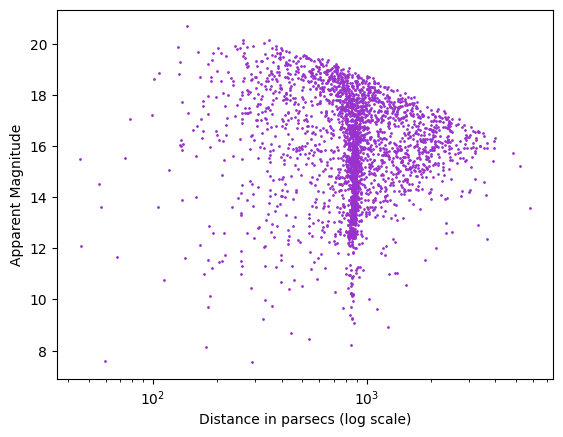

In [219]:
dist = 1000/r['parallax']   # since parallax is in milliarcseconds(mas) and distance(pc) = 1/parallax(arcsecond)
appmags = r['phot_g_mean_mag']

plt.scatter(dist, appmags, s=1, color = 'darkorchid')
plt.xscale('log')
plt.xlabel('Distance in parsecs (log scale)')
plt.ylabel('Apparent Magnitude')
plt.show()

There's a clearly visible overdensity at 800-900 pc. Let's retain only those stars from, say 500 to 1250 pc, and make a histogram

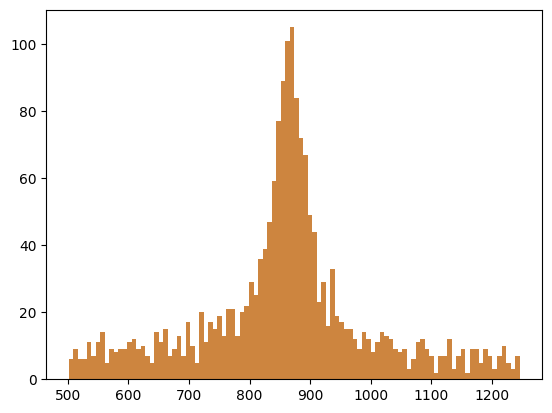

In [220]:
mask = r['parallax'] < (1000/500)
r = r[mask]
mask = r['parallax'] > (1000/1250)
r = r[mask]

plt.hist(1000/r['parallax'], bins = 100, color = 'peru')
plt.show()

The above histogram has two components - non cluster stars that can be modelled as a uniform distribution, and the cluster stars that can be modelled as a Gaussian. Let's do curve-fitting for that.

In [221]:
def f(x, A, m, s, c):
    return A*np.exp(-(x-m)**2/(2*s**2)) + c

y, x = np.histogram(1000/r['parallax'], bins = 100)

p, c = cf(f, [(x[i] + x[i+1])/2 for i in range(100)], y, p0 = [np.max(y), x[np.argmax(y)], np.std(y), 5])

I won't be explaining the above code cell right away. If any of the lines do not make sense, you are encouraged to look up the syntax. If doubts still persist, message me on Discord!

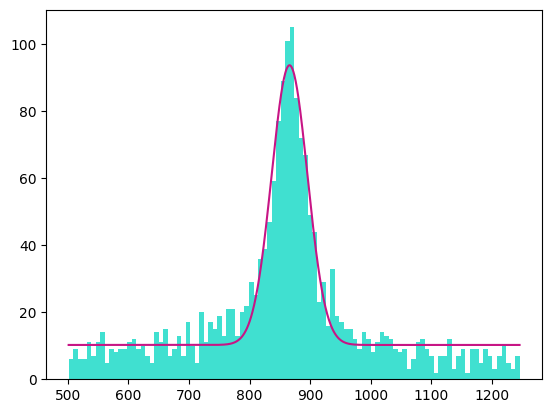

Cluster distance=865.9929745749389 with standard deviation=29.609183162498617


In [222]:
plt.hist(1000/r['parallax'], bins = 100, color = 'turquoise')
newx = np.linspace(x[0], x[-1], 1000)
plt.plot(newx, f(newx, p[0], p[1], p[2], p[3]), color = 'mediumvioletred')
plt.show()

print(f"Cluster distance={p[1]} with standard deviation={p[2]}")
dist = 1000 / r['parallax']
mask=(dist>p[1]-3*p[2]) & (dist<p[1]+3*p[2])
r=r[mask]


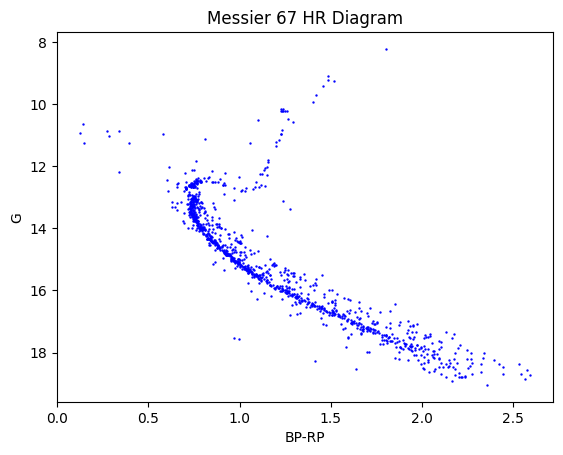

In [223]:

plt.scatter(r['phot_bp_mean_mag']-r['phot_rp_mean_mag'],r['phot_g_mean_mag'],s=0.5,color='b')
plt.gca().invert_yaxis()
plt.title('Messier 67 HR Diagram')
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.show()

The fit seems good! We can get the distance to the cluster (the mean m of curve fit) and the standard deviation (s of curve fit) and apply cuts saying stars within 3*std_dev of the mean are all cluster stars.

In [340]:
query1 = '''select top 10000 source_id, ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
from gaiadr3.gaia_source
where
ra between 307.5 and 308.5 and
dec between 60 and 61
and parallax_over_error > 5
order by parallax desc'''
job = Gaia.launch_job_async(query1)
r1 = job.get_results() #NGC6939

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


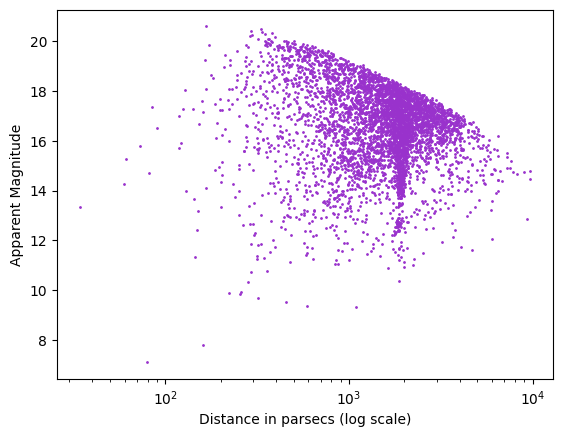

In [341]:
dist = 1000/r1['parallax']   # since parallax is in milliarcseconds(mas) and distance(pc) = 1/parallax(arcsecond)
appmags = r1['phot_g_mean_mag']

plt.scatter(dist, appmags, s=1, color = 'darkorchid')
plt.xscale('log')
plt.xlabel('Distance in parsecs (log scale)')
plt.ylabel('Apparent Magnitude')
plt.show()

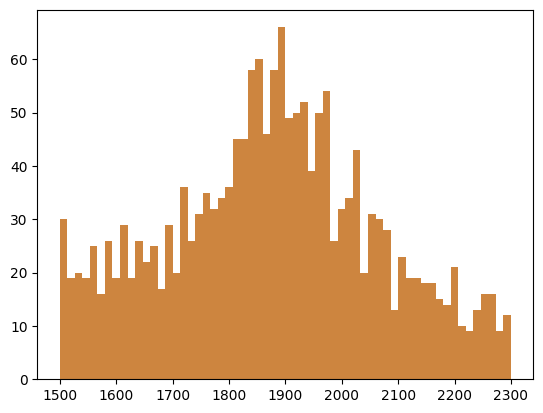

In [342]:
mask = r1['parallax'] < (1000/1500) # Corresponds to distance > 120 pc
r1 = r1[mask]
mask = r1['parallax'] > (1000/2300) # Corresponds to distance < 180 pc
r1 = r1[mask]

plt.hist(1000/r1['parallax'], bins = 60, color = 'peru')
plt.show()

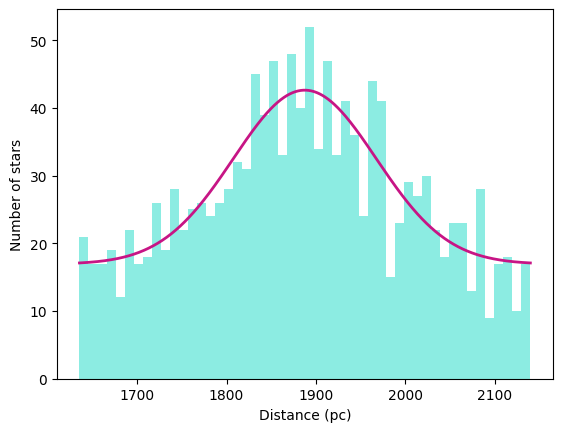

Cluster distance=1887.5469058783867 with standard deviation=79.94153394274312


In [350]:
def f(x, A, m, s, c):
    return A * np.exp(-(x - m)**2 / (2 * s**2)) + c

dist = 1000 / r1['parallax']
bins = 50
y, edges = np.histogram(dist, bins=bins)
x_centers = (edges[:-1] + edges[1:]) / 2

p0 = [np.max(y), np.mean(dist), np.std(dist), 0]
p, cov = cf(f, x_centers, y, p0=p0)
plt.hist(dist, bins=bins, color='turquoise', alpha=0.6)
newx = np.linspace(dist.min(), dist.max(), 1000)
plt.plot(newx, f(newx, *p), color='mediumvioletred', linewidth=2)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of stars')
plt.show()

print(f"Cluster distance={p[1]} with standard deviation={p[2]}")
dist=1000/r1['parallax']
mask=(dist>p[1]-3*p[2]) & (dist<p[1]+3*p[2])
r1=r1[mask]


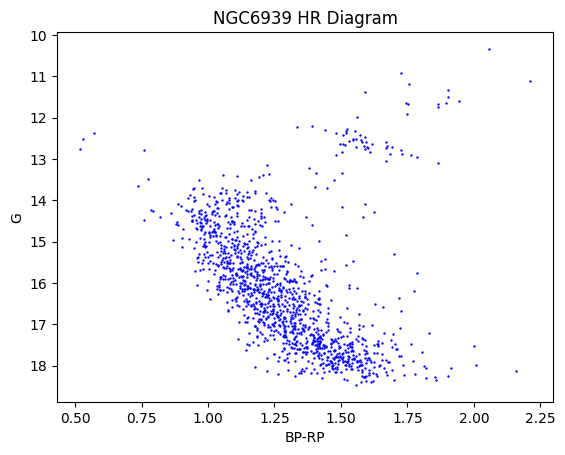

In [351]:
mask = (
    ~r1['phot_bp_mean_mag'].mask & (r1['phot_bp_mean_mag'] > 0) &
    ~r1['phot_rp_mean_mag'].mask & (r1['phot_rp_mean_mag'] > 0) &
    ~r1['phot_g_mean_mag'].mask & (r1['phot_g_mean_mag'] > 0)
)
r1 = r1[mask]
plt.scatter(r1['phot_bp_mean_mag']-r1['phot_rp_mean_mag'],r1['phot_g_mean_mag'],s=0.5,color='b')
plt.gca().invert_yaxis()
plt.title('NGC6939 HR Diagram')
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.show()

Perform this exercise for an open cluster of your choice(look up a list on wikipedia to find coordinates and change the above query accordingly)

Also try this out for the Draco Dwarf galaxy(The target we will be trying with GROWTH-India Telescope data). We can later compare results from GAIA and the data we have collected from GIT.<br> **Note:** You wouldn't get a very clean gaussian for Draco and you would need to tune certain parameters to get a cleaner HR diagram. Try this out and see if you can locate the Tip of Red-Giant Branch
